# Assignment 10: Research

1. Use *only* in-sample data when calibrating up till 2020 
2. Implement helper functions for curve, CRD, fly weights, and backtesting.
3. Produce PnL graphs:
    - Cumulative PnL
    - Simple-return index (base 100)
    - With vs without costs, long vs short, leg-level decomposition.
4. Compute full summary statistics (Part C spec): Sharpe, Calmar, Sortino, VaR/ES, IC, turnover, etc.
5. Provide diagnostics for normality and correlation vs major asset classes for later write-up.


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from scipy.interpolate import PchipInterpolator
from itertools import combinations
from scipy import stats as st

CURVE_PATH = Path("treasury_curve.parquet")
EVENT_PATH = Path("event_calendar.csv")

IS_END = pd.Timestamp("2021-12-31")
CUTOFF_DATE = pd.Timestamp("2019-12-31")  

H_MONTH = 1
H = H_MONTH / 12.0

ANNUAL_DAYS = 252
TARGET_DV01 = 100_000
CAPITAL_BASE = TARGET_DV01 * 100

MAX_HOLD_DAYS = 63
COST_BP_PER_SIDE = 0.15

# Following possible combinations
FLY_MATS = [2.0, 3.0, 5.0, 7.0, 10.0, 20.0, 30.0]

# Stage 1 – Build daily Treasury curve (spot yields)
 - Load from local parquet if available.
 - Otherwise download FRED DGS3MO–DGS30 and cache as parquet.
 - Convert yields to decimals; index by date, columns = maturities in years.

In [ ]:
def build_or_load_curve(curve_path: Path) -> pd.DataFrame:
    """
    Load daily Treasury yield curve (maturities as columns, decimal yields).

    Order of preference:
    1. Local parquet (curve_path)
    2. Download from FRED (DGS3MO–DGS30) and save as parquet.

    Returns
    -------
    DataFrame:
        index   : DatetimeIndex (date)
        columns : maturities in years (0.25, 0.5, 1, 2, ..., 30), decimal yields
    """
    if curve_path.exists():
        yc = pd.read_parquet(curve_path).sort_index()
        return yc

    series = [
        "DGS3MO", "DGS6MO", "DGS1", "DGS2", "DGS3",
        "DGS5", "DGS7", "DGS10", "DGS20", "DGS30"
    ]
    tenor_map = {
        "DGS3MO": 0.25,
        "DGS6MO": 0.5,
        "DGS1": 1.0,
        "DGS2": 2.0,
        "DGS3": 3.0,
        "DGS5": 5.0,
        "DGS7": 7.0,
        "DGS10": 10.0,
        "DGS20": 20.0,
        "DGS30": 30.0,
    }

    raw = web.DataReader(series, "fred", start="2015-01-01")
    yc = raw.dropna(how="all").ffill() / 100.0
    yc = yc.rename(columns=tenor_map)
    yc = yc[sorted(yc.columns, key=float)]
    yc.index.name = "date"

    try:
        yc.to_parquet(curve_path)
    except Exception:
        pass

    return yc


curve_full = build_or_load_curve(CURVE_PATH)
print("Full curve shape:", curve_full.shape)
print("Curve maturities:", curve_full.columns.tolist())


Loading curve from treasury_curve.csv
Could not read parquet (falling back to FRED download): Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.
treasury_curve.parquet not found or unreadable, downloading from FRED...
Could not save parquet (ok to ignore): Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optiona

# Stage 2 – Restrict to in-sample window


In [ ]:
curve_df = curve_full.loc[:IS_END].copy()
print("IS curve shape:", curve_df.shape)
print("IS date range:", curve_df.index.min(), "→", curve_df.index.max())

IS curve shape: (1752, 10)
IS date range: 2015-01-02 00:00:00 → 2021-12-31 00:00:00


# Stage 3 – Macro event calendar and event blocker
- Load CPI/FOMC/auction dates.
- Build a boolean blocker series over IS dates:
    - Block trades in a symmetric window around each event (e.g. ±2 days).


In [ ]:
def load_event_calendar(path: Path) -> pd.DataFrame:
    """
    Load macro event calendar (e.g. FOMC / CPI). We assume the CSV has:
        - 'date' column parsable as datetime
        - any other fields (ignored here)
    Each row is treated as an event date.
    """
    df = pd.read_csv(path, parse_dates=["date"])
    df = df.sort_values("date")
    return df


def build_event_blocker(idx: pd.DatetimeIndex,
                        event_df: pd.DataFrame,
                        window_days: int = 2) -> pd.Series:
    """
    Build an event blocker series over the provided index.
    
    For each event date d, we block trades from [d - window_days, d + window_days].
    
    Returns
    -------
    pd.Series
        Boolean Series indexed by idx; True when trading should be blocked.
    """
    blocked = pd.Series(False, index=idx)
    ev_dates = event_df["date"].dt.normalize().unique()
    for d in ev_dates:
        start = d - pd.Timedelta(days=window_days)
        end = d + pd.Timedelta(days=window_days)
        mask = (blocked.index >= start) & (blocked.index <= end)
        blocked.loc[mask] = True
    return blocked


event_df_full = load_event_calendar(EVENT_PATH)
event_df_is = event_df_full[event_df_full["date"] <= IS_END].copy()

event_block = build_event_blocker(curve_df.index, event_df_is, window_days=2)
print("Event-blocked days (IS):", event_block.sum(), "/", len(event_block))


Event-blocked days (IS): 564 / 1752


/var/folders/tl/hb3sh0p16wb8f6cdsnkjq_wm0000gn/T/ipykernel_85843/330707552.py:12: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(path, parse_dates=["date"])


# Stage 4 – Curve and CRD helper functions
- Zero-coupon pricing and DV01.
- Yield interpolation via PCHIP.
- Roll-down yield change over horizon H.
- Single-leg carry + roll-down (CRD) return.
- DV01-neutral, dollar-neutral fly weights (belly normalised to +1).


In [ ]:
def zero_coupon(y: float, T: float) -> tuple[float, float]:
    """
    Zero-coupon price and DV01 for maturity T (years) and yield y (decimal).

    P    = exp(-y * T)
    DV01 = P * T * 1bp
    """
    P = np.exp(-y * T)
    dv01 = P * T * 1e-4
    return P, dv01


def interp_yield(curve_row: pd.Series, T: float) -> float:
    """
    Interpolate yield at maturity T from a single-day curve.

    Uses PCHIP on the available maturities; falls back to linear extrapolation
    outside the observed range or if PCHIP fails.
    """
    xs = curve_row.index.values.astype(float)
    ys = curve_row.values.astype(float)
    order = np.argsort(xs)
    xs, ys = xs[order], ys[order]

    if len(xs) < 2:
        return float(np.interp(T, xs, ys))

    try:
        pchip = PchipInterpolator(xs, ys)
        if T < xs[0] or T > xs[-1]:
            return float(np.interp(T, xs, ys))
        return float(pchip(T))
    except Exception:
        return float(np.interp(T, xs, ys))


def roll_down_dy(curve_row: pd.Series, T: float, H: float) -> float:
    """
    Roll-down yield change from T to T − H on the current curve.

    Returns y(T − H) − y(T) in decimals. If T − H ≤ 0, returns 0.
    """
    if T - H <= 0:
        return 0.0
    y_T = interp_yield(curve_row, T)
    y_TH = interp_yield(curve_row, T - H)
    return y_TH - y_T


def crd_single_leg(
    curve_row: pd.Series,
    T: float,
    H: float,
    fund_rate: float,
) -> tuple[float, float, float]:
    """
    Carry + roll-down return over horizon H for a single zero-coupon leg.

    Parameters
    ----------
    curve_row : yields for that date (index = maturities, decimal yields)
    T         : maturity in years
    H         : horizon in years
    fund_rate : funding rate (decimal, e.g. 3M)

    Returns
    -------
    crd_ret : carry + roll-down return over H (per 1 notional)
    P       : zero-coupon price
    dv01    : DV01 per 1bp per 1 notional
    """
    y = interp_yield(curve_row, T)
    P, dv01 = zero_coupon(y, T)

    dy_roll = roll_down_dy(curve_row, T, H)
    dy_bps = dy_roll * 1e4

    roll_pnl = -dv01 * dy_bps
    carry = (y - fund_rate) * H * P

    crd_ret = (roll_pnl + carry) / P
    return crd_ret, P, dv01


def fly_weight_DV01_neutral(
    dv01_L: float,
    dv01_B: float,
    dv01_R: float,
) -> tuple[float, float, float]:
    """
    DV01-neutral, dollar-neutral fly weights with belly normalised to +1.

    Constraints
    ----------
    wL * dv01_L + wB * dv01_B + wR * dv01_R = 0     (DV01-neutral)
    wL + wB + wR = 0                               (dollar-neutral)
    wB = +1                                        (normalisation)

    Returns
    -------
    wL, wB, wR
    """
    A = np.array([[dv01_L, dv01_R],
                  [1.0,    1.0]])
    b = np.array([-dv01_B, -1.0])
    w_L, w_R = np.linalg.solve(A, b)
    return float(w_L), 1.0, float(w_R)

# Stage 5 – Compute CRD-based fly signal
- For each fly (T_L, T_B, T_R):
- Compute CRD for each leg.
- Compute DV01-neutral fly weights.
- Aggregate fly CRD over horizon H, annualise, normalise by |fly DV01|.
- Express as signal in bp/year per $1 DV01.
- Smooth with a 5-day moving average (`sig_bp`).

In [ ]:
def compute_fly_signal_for_curve(
    curve_df: pd.DataFrame,
    tenors: tuple[float, float, float],
    H: float,
) -> pd.DataFrame:
    """
    Compute daily CRD-based signal and DV01-neutral weights for a fly.

    Returns
    -------
    DataFrame indexed by date:
        sig_raw_bp : raw annualised CRD signal (bp/year per 1$ DV01)
        sig_bp     : 5D MA of sig_raw_bp
        wL, wB, wR : fly weights
        fly_dv01   : total absolute DV01 of the fly per 1 notional
    """
    T_L, T_B, T_R = tenors
    rows = []

    for date, row in curve_df.iterrows():
        fund_rate = float(row.iloc[0])

        crd_L, P_L, dv01_L = crd_single_leg(row, T_L, H, fund_rate)
        crd_B, P_B, dv01_B = crd_single_leg(row, T_B, H, fund_rate)
        crd_R, P_R, dv01_R = crd_single_leg(row, T_R, H, fund_rate)

        wL, wB, wR = fly_weight_DV01_neutral(dv01_L, dv01_B, dv01_R)

        fly_crd_H = (
            wL * P_L * crd_L +
            wB * P_B * crd_B +
            wR * P_R * crd_R
        )
        fly_crd_annual = fly_crd_H / H

        fly_dv01_abs = (
            abs(wL * dv01_L) +
            abs(wB * dv01_B) +
            abs(wR * dv01_R)
        )

        sig_raw_bp = (fly_crd_annual / max(fly_dv01_abs, 1e-12)) * 1e4

        rows.append(
            {
                "date": date,
                "sig_raw_bp": sig_raw_bp,
                "wL": wL,
                "wB": wB,
                "wR": wR,
                "fly_dv01": fly_dv01_abs,
            }
        )

    sig_df = pd.DataFrame(rows).set_index("date")
    sig_df["sig_bp"] = sig_df["sig_raw_bp"].rolling(5, min_periods=1).mean()
    return sig_df

# Stage 6 – Regime filter (2s10s slope stability)
- Only allow entries when 2s10s slope is “stable”.
- Criterion: 20-day average absolute daily change < 5 bp.


In [ ]:
if 2.0 in curve_df.columns and 10.0 in curve_df.columns:
    slope_2_10 = curve_df[10.0] - curve_df[2.0]
    slope_chg_20d = slope_2_10.diff().abs().rolling(20).mean()
    regime_ok = slope_chg_20d < 0.0005   # 5bp in decimal
else:
    regime_ok = pd.Series(True, index=curve_df.index)

print("Regime-ok days (IS):", regime_ok.sum(), "/", len(regime_ok))


Regime-ok days (IS): 1714 / 1752


# Stage 7 – Generic CRD backtester (IS only)
- Uses `sig_bp` for entries/exits.
- Entry / exit thresholds from *IS only* via quantiles (no OOS peeking).
- Event blocker and regime filter respected.
- Scale positions to target |DV01| per trade.
- Include per-side transaction costs; track daily PnL and returns.

In [ ]:
def run_crd_backtest(
    curve_df: pd.DataFrame,
    signal_df: pd.DataFrame,
    tenors: tuple[float, float, float],
    regime_ok: pd.Series,
    event_block: pd.Series,
    entry_quantile: float = 0.85,
    exit_quantile: float = 0.50,
) -> pd.DataFrame:
    """
    CRD-based fly backtest over IS.

    Trading logic
    -------------
    - Signal: sig_bp (5D MA).
    - Entry/exit thresholds: absolute signal quantiles on stable regime days.
    - Only open positions when regime_ok and not event_block.
    - Long fly when sig > ENTRY_SIG; short fly when sig < −ENTRY_SIG.
    - Exit when |sig| < EXIT_SIG or holding period ≥ MAX_HOLD_DAYS.
    - Flatten around macro events.
    - Scale to |DV01| = TARGET_DV01 and include transaction costs.
    """
    dates = signal_df.index

    stable_sig = signal_df.loc[regime_ok, "sig_bp"].dropna()
    abs_sig = stable_sig.abs()
    ENTRY_SIG = abs_sig.quantile(entry_quantile)
    EXIT_SIG = abs_sig.quantile(exit_quantile)

    print(f"ENTRY_SIG (bp/yr per $DV01): {ENTRY_SIG:.4f}")
    print(f"EXIT_SIG  (bp/yr per $DV01): {EXIT_SIG:.4f}")

    T_L, T_B, T_R = tenors

    def zero_price_from_curve(curve_row: pd.Series, T: float) -> float:
        y = interp_yield(curve_row, T)
        P, _ = zero_coupon(y, T)
        return P

    prev_curve = None
    prev_pos_dir = 0
    prev_wL = prev_wB = prev_wR = 0.0
    prev_scale = 0.0
    prev_hold_days = 0

    bt_rows = []

    for date in dates:
        curve_today = curve_df.loc[date]
        sig = signal_df.loc[date, "sig_bp"]
        wL_sig = signal_df.loc[date, "wL"]
        wB_sig = signal_df.loc[date, "wB"]
        wR_sig = signal_df.loc[date, "wR"]
        fly_dv01_sig = signal_df.loc[date, "fly_dv01"]

        is_regime_ok = bool(regime_ok.get(date, True))
        is_event_block = bool(event_block.get(date, False))

        daily_pnl = 0.0
        if prev_curve is not None and prev_pos_dir != 0 and prev_scale > 0:
            P_L0 = zero_price_from_curve(prev_curve, T_L)
            P_B0 = zero_price_from_curve(prev_curve, T_B)
            P_R0 = zero_price_from_curve(prev_curve, T_R)

            P_L1 = zero_price_from_curve(curve_today, T_L)
            P_B1 = zero_price_from_curve(curve_today, T_B)
            P_R1 = zero_price_from_curve(curve_today, T_R)

            fly_leg_pnl = (
                prev_wL * (P_L1 - P_L0) +
                prev_wB * (P_B1 - P_B0) +
                prev_wR * (P_R1 - P_R0)
            )

            dt = 1.0 / ANNUAL_DAYS
            fund_prev = float(prev_curve.iloc[0])
            y_L_prev = interp_yield(prev_curve, T_L)
            y_B_prev = interp_yield(prev_curve, T_B)
            y_R_prev = interp_yield(prev_curve, T_R)

            carry_L = (y_L_prev - fund_prev) * dt * P_L0
            carry_B = (y_B_prev - fund_prev) * dt * P_B0
            carry_R = (y_R_prev - fund_prev) * dt * P_R0

            fly_carry = (
                prev_wL * carry_L +
                prev_wB * carry_B +
                prev_wR * carry_R
            )

            daily_pnl = (fly_leg_pnl + fly_carry) * prev_scale * prev_pos_dir

        new_pos_dir = prev_pos_dir
        new_wL, new_wB, new_wR = prev_wL, prev_wB, prev_wR
        new_scale = prev_scale
        new_hold_days = prev_hold_days

        if is_event_block and prev_pos_dir != 0:
            new_pos_dir = 0
            new_scale = 0.0
            new_hold_days = 0

        elif prev_pos_dir == 0:
            if (not is_event_block) and is_regime_ok and not np.isnan(sig):
                if sig > ENTRY_SIG:
                    new_pos_dir = 1
                    new_wL, new_wB, new_wR = wL_sig, wB_sig, wR_sig
                    new_scale = TARGET_DV01 / max(fly_dv01_sig, 1e-12)
                    new_hold_days = 0
                elif sig < -ENTRY_SIG:
                    new_pos_dir = -1
                    new_wL, new_wB, new_wR = wL_sig, wB_sig, wR_sig
                    new_scale = TARGET_DV01 / max(fly_dv01_sig, 1e-12)
                    new_hold_days = 0

        else:
            new_hold_days = prev_hold_days + 1
            exit_cond = (abs(sig) < EXIT_SIG) or (new_hold_days >= MAX_HOLD_DAYS)
            if exit_cond:
                new_pos_dir = 0
                new_scale = 0.0
                new_hold_days = 0

        trade_cost = 0.0
        if new_pos_dir != prev_pos_dir:
            step_units = 1 if (prev_pos_dir == 0 or new_pos_dir == 0) else 2
            trade_cost = step_units * COST_BP_PER_SIDE * 1e-4 * TARGET_DV01
            daily_pnl -= trade_cost

        bt_rows.append(
            {
                "date": date,
                "sig_bp": sig,
                "pos_dir": prev_pos_dir,
                "daily_pnl": daily_pnl,
                "hold_days": prev_hold_days,
                "regime_ok": is_regime_ok,
                "event_block": is_event_block,
                "trade_cost": trade_cost,
            }
        )

        prev_curve = curve_today
        prev_pos_dir = new_pos_dir
        prev_wL, prev_wB, prev_wR = new_wL, new_wB, new_wR
        prev_scale = new_scale
        prev_hold_days = new_hold_days

    bt = pd.DataFrame(bt_rows).set_index("date")
    bt["cum_pnl"] = bt["daily_pnl"].cumsum()
    bt["ret"] = bt["daily_pnl"] / CAPITAL_BASE
    bt["cum_ret"] = (1 + bt["ret"].fillna(0)).cumprod() - 1
    return bt

# Stage 8 – Basic performance statistics helper (IS only)
- Annualised return, volatility, Sharpe.
- Total PnL, non-zero position days, total trade cost.
- Used inside the fly leaderboard.

In [ ]:
def perf_stats(bt: pd.DataFrame, trading_days: int = 252) -> pd.Series:
    """
    Basic performance statistics from a backtest DataFrame with 'ret' column.
    """
    valid = bt["ret"].replace([np.inf, -np.inf], np.nan).dropna()
    if len(valid) <= 1:
        ann_ret = ann_vol = sharpe = np.nan
    else:
        ann_ret = valid.mean() * trading_days
        ann_vol = valid.std(ddof=1) * np.sqrt(trading_days)
        sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan

    return pd.Series(
        {
            "ann_return": ann_ret,
            "ann_vol": ann_vol,
            "sharpe": sharpe,
            "total_pnl": bt["daily_pnl"].sum(),
            "non_zero_days": (bt["pos_dir"] != 0).sum(),
            "total_trade_cost": bt["trade_cost"].sum(),
        }
    )

# Stage 9 – Build and test all fly combinations (IS only)
- Generate all tenor triplets from `FLY_MATS`.
- For each fly:
  - Build CRD signal.
  - Run backtest.
  - Compute basic stats.
- Summarise and rank by Sharpe (IS).

In [ ]:

FLY_SPECS = {
    f"{int(a)}s{int(b)}s{int(c)}s": (a, b, c)
    for (a, b, c) in combinations(FLY_MATS, 3)
}

print("Number of flies to test:", len(FLY_SPECS))
print("Example flies:", list(FLY_SPECS.items())[:5])

fly_results: dict[str, dict] = {}
summary_rows: list[pd.Series] = []

for name, tenors in FLY_SPECS.items():
    print("\n===============================")
    print(f"Fly: {name}  (tenors={tenors})")
    print("===============================")

    sig_df = compute_fly_signal_for_curve(curve_df, tenors, H)

    bt = run_crd_backtest(
        curve_df=curve_df,
        signal_df=sig_df,
        tenors=tenors,
        regime_ok=regime_ok,
        event_block=event_block,
        entry_quantile=0.85,
        exit_quantile=0.50,
    )

    stats = perf_stats(bt)
    stats["fly_name"] = name
    stats["T_L"], stats["T_B"], stats["T_R"] = tenors

    fly_results[name] = {"signal": sig_df, "bt": bt, "stats": stats}
    summary_rows.append(stats)

summary_df = pd.DataFrame(summary_rows).set_index("fly_name")
summary_df_sorted = summary_df.sort_values("sharpe", ascending=False)

print("\n=== IS-only performance summary (sorted by Sharpe) ===")
display(summary_df_sorted.head(10))


Number of flies to test: 35
Example flies: [('2s3s5s', (2.0, 3.0, 5.0)), ('2s3s7s', (2.0, 3.0, 7.0)), ('2s3s10s', (2.0, 3.0, 10.0)), ('2s3s20s', (2.0, 3.0, 20.0)), ('2s3s30s', (2.0, 3.0, 30.0))]

Fly: 2s3s5s  (tenors=(2.0, 3.0, 5.0))
ENTRY_SIG (bp/yr per $DV01): 18675.0821
EXIT_SIG  (bp/yr per $DV01): 7241.0193

Fly: 2s3s7s  (tenors=(2.0, 3.0, 7.0))
ENTRY_SIG (bp/yr per $DV01): 37895.1784
EXIT_SIG  (bp/yr per $DV01): 13511.8601

Fly: 2s3s10s  (tenors=(2.0, 3.0, 10.0))
ENTRY_SIG (bp/yr per $DV01): 53233.5058
EXIT_SIG  (bp/yr per $DV01): 18937.0673

Fly: 2s3s20s  (tenors=(2.0, 3.0, 20.0))
ENTRY_SIG (bp/yr per $DV01): 67876.1160
EXIT_SIG  (bp/yr per $DV01): 26599.0015

Fly: 2s3s30s  (tenors=(2.0, 3.0, 30.0))
ENTRY_SIG (bp/yr per $DV01): 74402.3507
EXIT_SIG  (bp/yr per $DV01): 30130.1104

Fly: 2s5s7s  (tenors=(2.0, 5.0, 7.0))
ENTRY_SIG (bp/yr per $DV01): 38175.8528
EXIT_SIG  (bp/yr per $DV01): 21067.6128

Fly: 2s5s10s  (tenors=(2.0, 5.0, 10.0))
ENTRY_SIG (bp/yr per $DV01): 67317.5357
EXIT_

,ann_return,ann_vol,sharpe,total_pnl,non_zero_days,total_trade_cost,T_L,T_B,T_R
fly_name,,,,,,,,,
2s5s10s,0.013527,0.037266,0.362997,940482.687060,207.0,66.0,2.0,5.0,10.0
7s20s30s,0.009583,0.029394,0.326003,666220.484055,268.0,78.0,7.0,20.0,30.0
10s20s30s,0.010066,0.031050,0.324198,699842.165425,249.0,69.0,10.0,20.0,30.0
2s3s10s,0.011762,0.042962,0.273785,817767.026736,224.0,72.0,2.0,3.0,10.0
2s3s20s,0.010059,0.050232,0.200259,699361.215961,233.0,78.0,2.0,3.0,20.0
2s5s7s,0.004550,0.027574,0.165012,316336.739133,209.0,66.0,2.0,5.0,7.0
3s5s7s,0.003678,0.024528,0.149954,255717.009950,241.0,72.0,3.0,5.0,7.0
3s5s10s,0.004600,0.030901,0.148847,319778.979550,223.0,63.0,3.0,5.0,10.0
2s3s30s,0.006655,0.047968,0.138741,462693.911763,207.0,72.0,2.0,3.0,30.0


# Stage 10A – PnL Plots
- Plot cumulative PnL for top-3 and bottom-3 flies by Sharpe (cutoff stats).
- Use pre-2020 segment only.

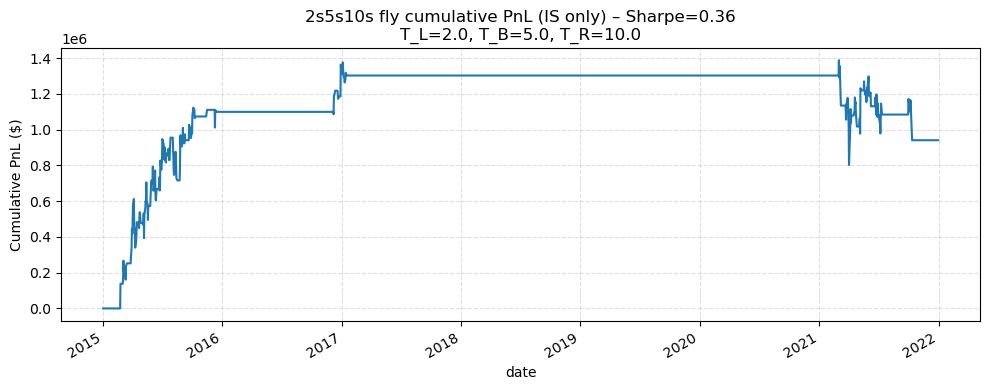

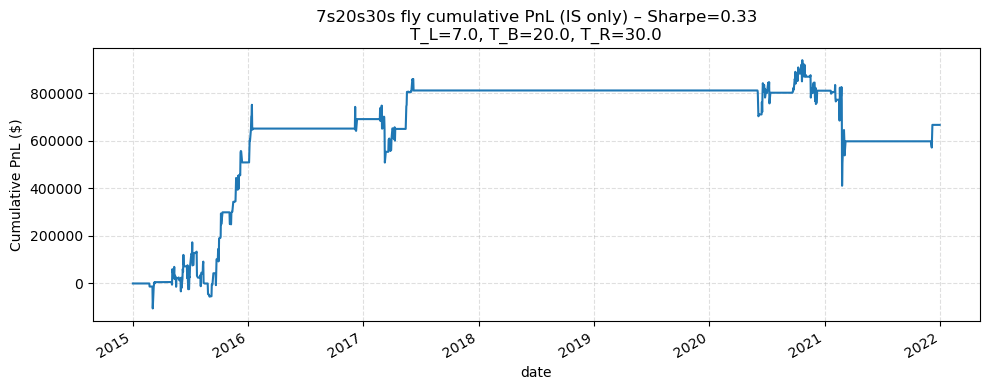

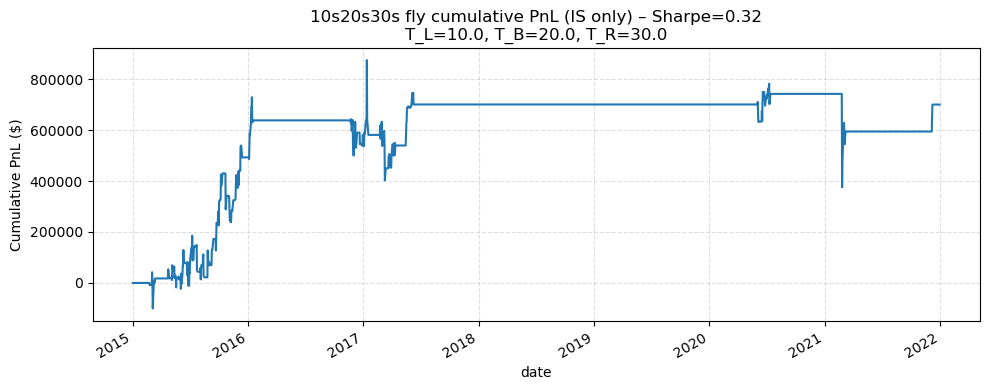

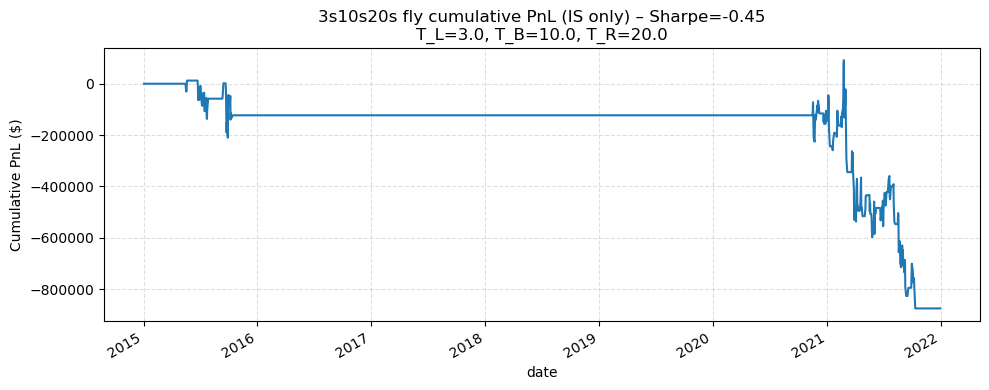

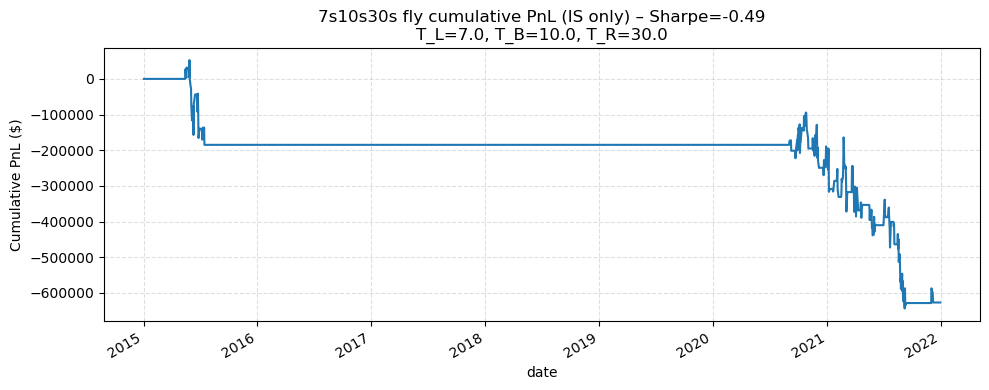

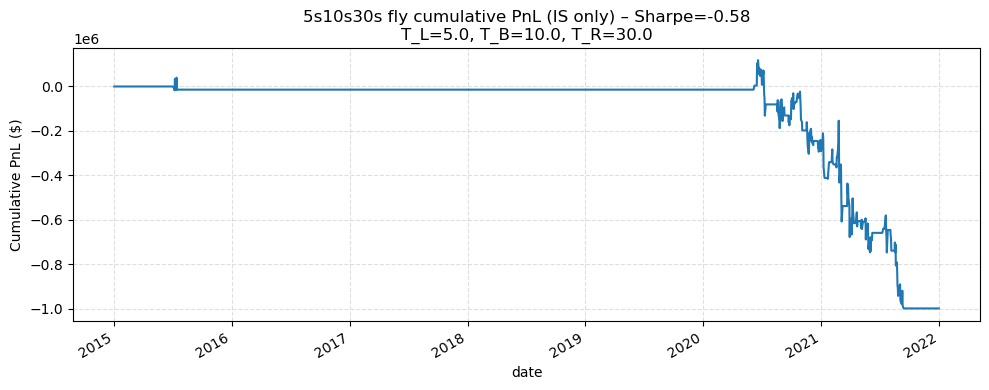

In [ ]:
top_flies = summary_df_sorted.head(3).index.tolist()
bottom_flies = summary_df_sorted.tail(3).index.tolist()

for name in top_flies + bottom_flies:
    bt = fly_results[name]["bt"]
    T_L = fly_results[name]["stats"]["T_L"]
    T_B = fly_results[name]["stats"]["T_B"]
    T_R = fly_results[name]["stats"]["T_R"]
    sharpe = fly_results[name]["stats"]["sharpe"]

    plt.figure(figsize=(10, 4))
    bt["cum_pnl"].plot()
    plt.title(f"{name} fly cumulative PnL (IS only) – Sharpe={sharpe:.2f}\n"
              f"T_L={T_L}, T_B={T_B}, T_R={T_R}")
    plt.ylabel("Cumulative PnL ($)")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()


# Stage 10B – Fly performance leaderboard (≤ 2019-12-31)
- Recompute stats using only data up to `CUTOFF_DATE`.
- Build Sharpe-sorted leaderboard across all flies.
- Use this ranking for plots and Part C discussion.

In [ ]:
TRADING_DAYS = ANNUAL_DAYS

def compute_fly_stats(
    bt: pd.DataFrame,
    capital_base: float = CAPITAL_BASE,
    trading_days: int = TRADING_DAYS,
) -> pd.Series:
    """
    Performance statistics for a single fly, restricted to CUTOFF_DATE.
    """
    bt = bt.loc[:CUTOFF_DATE].copy()

    if bt.empty:
        return pd.Series(
            {
                "ann_return": np.nan,
                "ann_vol": np.nan,
                "sharpe": np.nan,
                "total_pnl": 0.0,
                "hit_rate": np.nan,
                "non_zero_days": 0,
                "num_trades": 0,
                "max_drawdown": np.nan,
            }
        )

    pnl = bt["daily_pnl"].astype(float)
    ret = pnl / capital_base
    ret = ret.replace([np.inf, -np.inf], np.nan).dropna()

    if len(ret) > 1:
        ann_ret = ret.mean() * trading_days
        ann_vol = ret.std(ddof=1) * np.sqrt(trading_days)
        sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
    else:
        ann_ret = ann_vol = sharpe = np.nan

    total_pnl = pnl.sum()
    hit_rate = (pnl > 0).mean()
    non_zero_days = (bt["pos_dir"] != 0).sum()

    pos_change = bt["pos_dir"].fillna(0).diff().ne(0)
    num_trades = ((pos_change) & (bt["pos_dir"] != 0)).sum()

    running_max = bt["cum_pnl"].cummax()
    drawdown = running_max - bt["cum_pnl"]
    max_dd = drawdown.max()

    return pd.Series(
        {
            "ann_return": ann_ret,
            "ann_vol": ann_vol,
            "sharpe": sharpe,
            "total_pnl": total_pnl,
            "hit_rate": hit_rate,
            "non_zero_days": non_zero_days,
            "num_trades": num_trades,
            "max_drawdown": max_dd,
        }
    )


all_bt = {name: fr["bt"] for name, fr in fly_results.items()}
fly_stats_list: list[pd.Series] = []

for fly_name, bt in all_bt.items():
    stats = compute_fly_stats(bt)
    stats.name = fly_name
    fly_stats_list.append(stats)

fly_stats = pd.DataFrame(fly_stats_list)
fly_stats_sorted = fly_stats.sort_values("sharpe", ascending=False)

print("======================================================")
print("  FLY PERFORMANCE LEADERBOARD (IS ONLY, ≤ 2019-12-31) ")
print("======================================================")
display(fly_stats_sorted)

print("\nTop 5:")
display(fly_stats_sorted.head(5))

print("\nWorst 5:")
display(fly_stats_sorted.tail(5))

  FLY PERFORMANCE LEADERBOARD (IS ONLY, ≤ 2019-12-31) 


,ann_return,ann_vol,sharpe,total_pnl,hit_rate,non_zero_days,num_trades,max_drawdown
2s5s10s,0.026253,0.032871,0.798666,1.302233e+06,0.0616,140.0,15.0,272354.460924
5s20s30s,0.012854,0.017376,0.739751,6.375914e+05,0.0416,92.0,8.0,156225.179353
2s3s10s,0.032347,0.044310,0.730025,1.604538e+06,0.0824,178.0,18.0,295572.610309
7s20s30s,0.016344,0.024538,0.666080,8.107226e+05,0.0832,177.0,16.0,242671.482775
2s3s20s,0.032450,0.049094,0.660971,1.609602e+06,0.0704,152.0,16.0,348369.724166
2s5s30s,0.029016,0.049391,0.587470,1.439263e+06,0.0552,127.0,13.0,471246.534361
3s5s10s,0.012695,0.023671,0.536299,6.297066e+05,0.0664,152.0,14.0,190604.137225
2s3s30s,0.025571,0.047957,0.533203,1.268407e+06,0.0600,134.0,15.0,401838.734443
2s5s20s,0.023808,0.044886,0.530417,1.180955e+06,0.0560,130.0,13.0,412327.601564
2s20s30s,0.008184,0.015589,0.524994,4.059691e+05,0.0320,70.0,6.0,150182.043202



Top 5:


,ann_return,ann_vol,sharpe,total_pnl,hit_rate,non_zero_days,num_trades,max_drawdown
2s5s10s,0.026253,0.032871,0.798666,1.302233e+06,0.0616,140.0,15.0,272354.460924
5s20s30s,0.012854,0.017376,0.739751,6.375914e+05,0.0416,92.0,8.0,156225.179353
2s3s10s,0.032347,0.044310,0.730025,1.604538e+06,0.0824,178.0,18.0,295572.610309
7s20s30s,0.016344,0.024538,0.666080,8.107226e+05,0.0832,177.0,16.0,242671.482775
2s3s20s,0.032450,0.049094,0.660971,1.609602e+06,0.0704,152.0,16.0,348369.724166



Worst 5:


,ann_return,ann_vol,sharpe,total_pnl,hit_rate,non_zero_days,num_trades,max_drawdown
7s10s20s,-0.003027,0.018319,-0.165237,-150149.830461,0.0368,108.0,11.0,305828.103967
3s10s20s,-0.002480,0.013153,-0.188527,-122998.241137,0.0160,40.0,5.0,222276.451243
5s7s10s,-0.003138,0.013026,-0.240888,-155646.137192,0.0296,73.0,12.0,377180.033011
7s10s30s,-0.003728,0.009662,-0.385896,-184939.762990,0.0128,34.0,3.0,237519.365134
5s10s20s,0.000000,0.000000,NaN,0.000000,0.0000,0.0,0.0,0.000000


# Stage 10C – Simple-return index plots (base 100, ≤ 2019-12-31)
- Convert daily PnL to simple cumulative returns (no compounding).
- Build index starting at 100 and plot for top / bottom flies

Top flies (by Sharpe, ≤ 2019-12-31): ['2s5s10s', '5s20s30s', '2s3s10s']
Bottom flies (by Sharpe, ≤ 2019-12-31): ['5s7s10s', '7s10s30s', '5s10s20s']


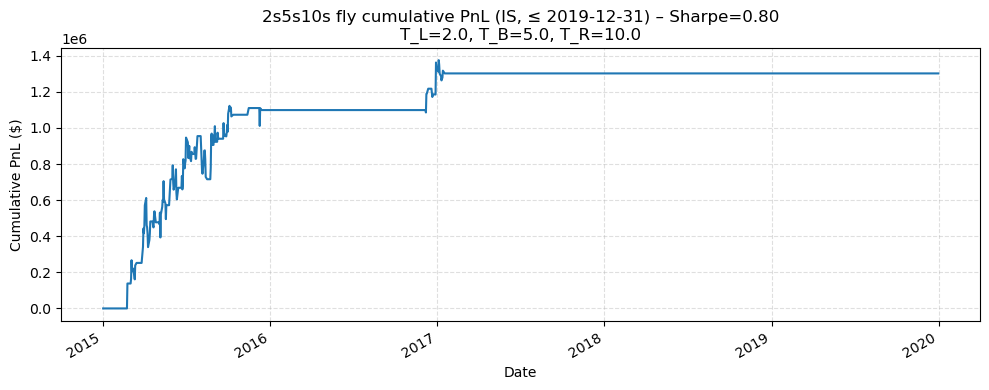

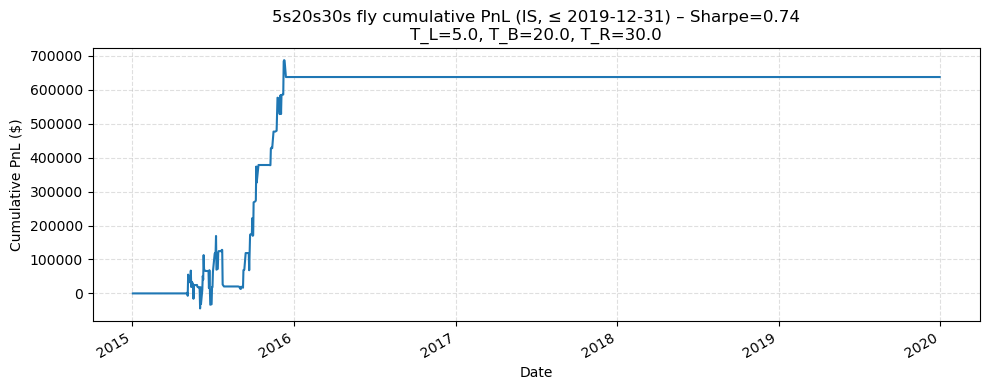

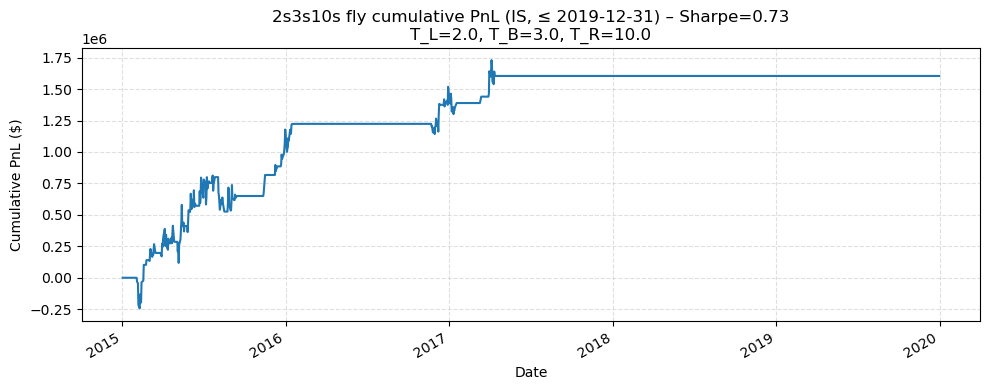

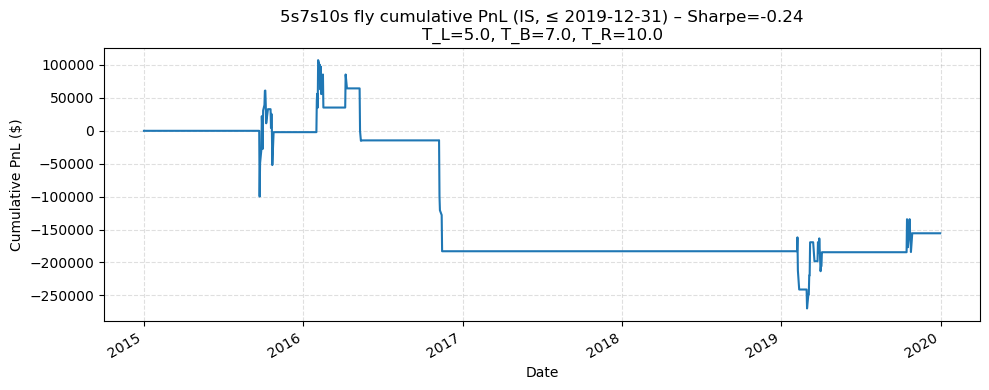

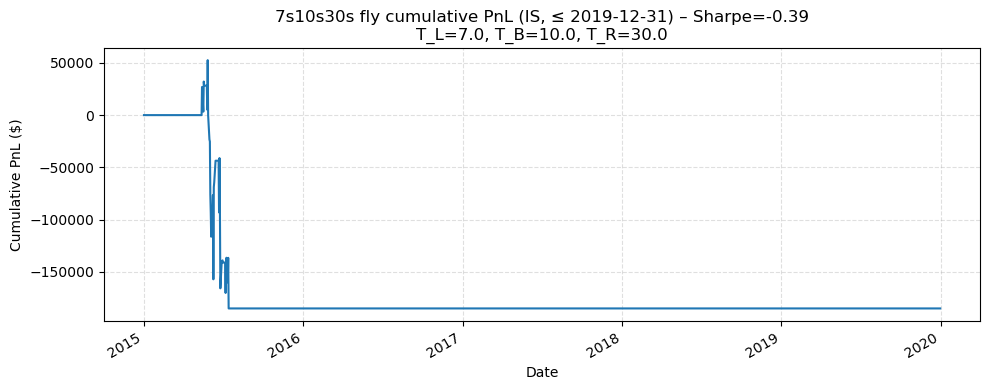

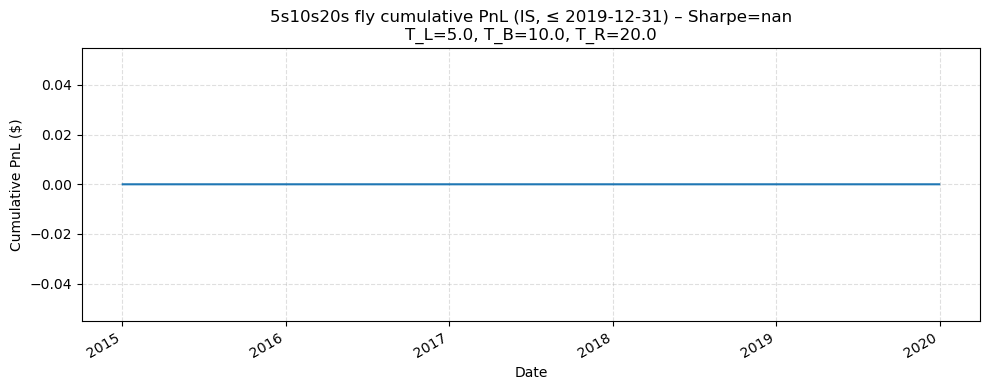

In [ ]:
for name in top_flies + bottom_flies:
    bt_full = fly_results[name]["bt"]
    bt = bt_full.loc[:CUTOFF_DATE].copy()
    if bt.empty:
        print(f"Skipping {name} – no data before {CUTOFF_DATE.date()}")
        continue

    daily_ret = (bt["daily_pnl"] / CAPITAL_BASE).fillna(0.0)
    cum_simple = daily_ret.cumsum()
    fly_index = 100.0 * (1.0 + cum_simple)
    fly_index.name = "index_level"

    T_L = fly_results[name]["stats"]["T_L"]
    T_B = fly_results[name]["stats"]["T_B"]
    T_R = fly_results[name]["stats"]["T_R"]
    sharpe_cutoff = fly_stats_sorted.loc[name, "sharpe"]

    plt.figure(figsize=(10, 4))
    fly_index.plot()
    plt.title(
        f"{name} fly simple-return index \n"
        f"Sharpe={sharpe_cutoff:.2f},  T_L={T_L}, T_B={T_B}, T_R={T_R}"
    )
    plt.ylabel("Index level (simple cum return, base = 100)")
    plt.xlabel("Date")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

# Stage 11A – 2s5s10s variants: costs / long-only / short-only (≤ 2019-12-31)
- Re-run the best fly (2s5s10s) with:
  - With costs vs no costs.
  - Long-only vs short-only.
- Plot simple-return indices starting at 100 to visualise differences.

Top flies (by Sharpe, ≤ 2019-12-31): ['2s5s10s', '5s20s30s', '2s3s10s']
Bottom flies (by Sharpe, ≤ 2019-12-31): ['5s7s10s', '7s10s30s', '5s10s20s']


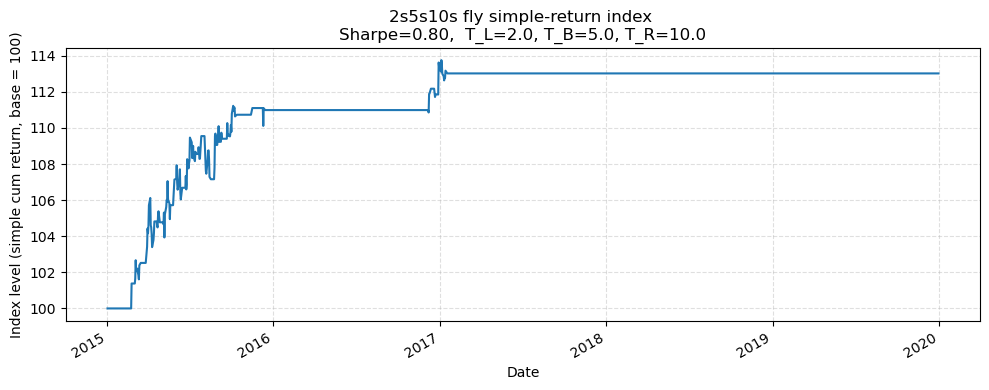

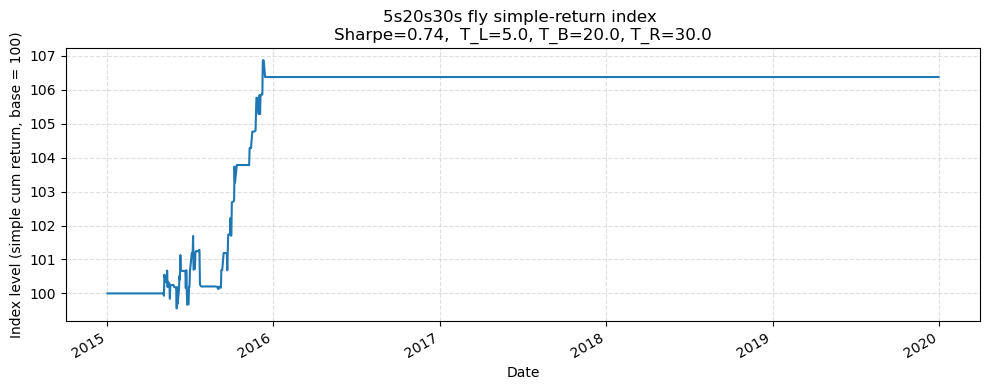

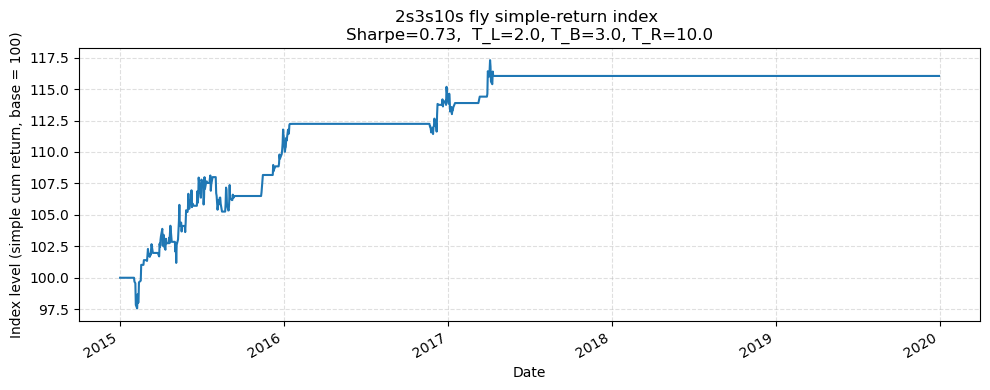

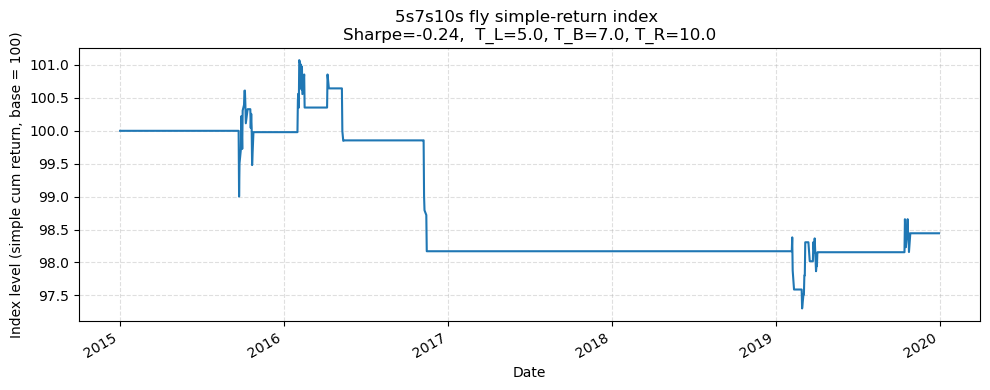

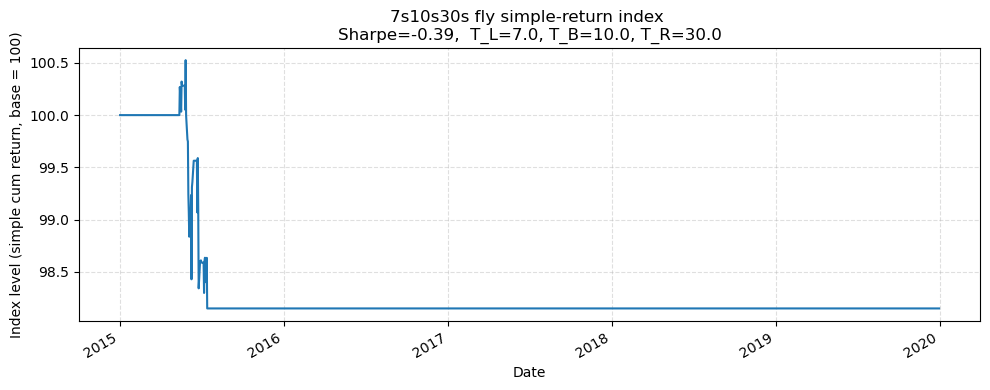

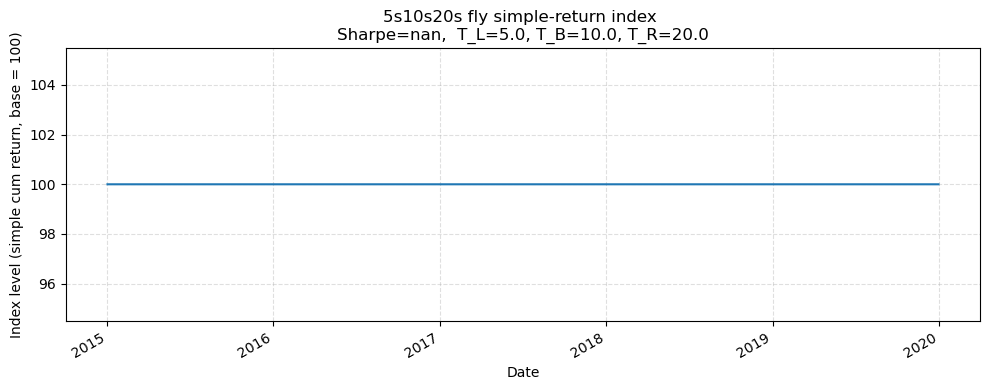

In [ ]:
BEST_FLY_NAME = "2s5s10s"
BEST_TENORS = (2.0, 5.0, 10.0)

sig_2s5s10s = compute_fly_signal_for_curve(curve_df, BEST_TENORS, H)
regime_ok_is = regime_ok.loc[curve_df.index]
event_block_is = event_block.loc[curve_df.index]

def run_crd_backtest_variant(
    curve_df: pd.DataFrame,
    signal_df: pd.DataFrame,
    tenors: tuple[float, float, float],
    regime_ok: pd.Series,
    event_block: pd.Series,
    entry_quantile: float = 0.85,
    exit_quantile: float = 0.50,
    cost_bp_per_side: float = COST_BP_PER_SIDE,
    long_only: bool = False,
    short_only: bool = False,
) -> pd.DataFrame:
    """
    CRD fly backtest with configurable costs and long-only / short-only options.
    """
    dates = signal_df.index

    stable_sig = signal_df.loc[regime_ok, "sig_bp"].dropna()
    abs_sig = stable_sig.abs()
    ENTRY_SIG = abs_sig.quantile(entry_quantile)
    EXIT_SIG = abs_sig.quantile(exit_quantile)

    print(f"[{tenors}] ENTRY_SIG: {ENTRY_SIG:.4f}, EXIT_SIG: {EXIT_SIG:.4f}")

    T_L, T_B, T_R = tenors

    def zero_price_from_curve(curve_row: pd.Series, T: float) -> float:
        y = interp_yield(curve_row, T)
        P, _ = zero_coupon(y, T)
        return P

    prev_curve = None
    prev_pos_dir = 0
    prev_wL = prev_wB = prev_wR = 0.0
    prev_scale = 0.0
    prev_hold_days = 0

    bt_rows = []

    for date in dates:
        curve_today = curve_df.loc[date]
        sig = signal_df.loc[date, "sig_bp"]
        wL_sig = signal_df.loc[date, "wL"]
        wB_sig = signal_df.loc[date, "wB"]
        wR_sig = signal_df.loc[date, "wR"]
        fly_dv01_sig = signal_df.loc[date, "fly_dv01"]

        is_regime_ok = bool(regime_ok.get(date, True))
        is_event_block = bool(event_block.get(date, False))

        daily_pnl = 0.0
        if prev_curve is not None and prev_pos_dir != 0 and prev_scale > 0:
            P_L0 = zero_price_from_curve(prev_curve, T_L)
            P_B0 = zero_price_from_curve(prev_curve, T_B)
            P_R0 = zero_price_from_curve(prev_curve, T_R)

            P_L1 = zero_price_from_curve(curve_today, T_L)
            P_B1 = zero_price_from_curve(curve_today, T_B)
            P_R1 = zero_price_from_curve(curve_today, T_R)

            fly_leg_pnl = (
                prev_wL * (P_L1 - P_L0) +
                prev_wB * (P_B1 - P_B0) +
                prev_wR * (P_R1 - P_R0)
            )

            dt = 1.0 / ANNUAL_DAYS
            fund_prev = float(prev_curve.iloc[0])
            y_L_prev = interp_yield(prev_curve, T_L)
            y_B_prev = interp_yield(prev_curve, T_B)
            y_R_prev = interp_yield(prev_curve, T_R)

            carry_L = (y_L_prev - fund_prev) * dt * P_L0
            carry_B = (y_B_prev - fund_prev) * dt * P_B0
            carry_R = (y_R_prev - fund_prev) * dt * P_R0

            fly_carry = (
                prev_wL * carry_L +
                prev_wB * carry_B +
                prev_wR * carry_R
            )

            daily_pnl = (fly_leg_pnl + fly_carry) * prev_scale * prev_pos_dir

        new_pos_dir = prev_pos_dir
        new_wL, new_wB, new_wR = prev_wL, prev_wB, prev_wR
        new_scale = prev_scale
        new_hold_days = prev_hold_days

        if is_event_block and prev_pos_dir != 0:
            new_pos_dir = 0
            new_scale = 0.0
            new_hold_days = 0

        elif prev_pos_dir == 0:
            if (not is_event_block) and is_regime_ok and not np.isnan(sig):
                if (not short_only) and sig > ENTRY_SIG:
                    new_pos_dir = 1
                    new_wL, new_wB, new_wR = wL_sig, wB_sig, wR_sig
                    new_scale = TARGET_DV01 / max(fly_dv01_sig, 1e-12)
                    new_hold_days = 0
                elif (not long_only) and sig < -ENTRY_SIG:
                    new_pos_dir = -1
                    new_wL, new_wB, new_wR = wL_sig, wB_sig, wR_sig
                    new_scale = TARGET_DV01 / max(fly_dv01_sig, 1e-12)
                    new_hold_days = 0

        else:
            new_hold_days = prev_hold_days + 1
            exit_cond = (abs(sig) < EXIT_SIG) or (new_hold_days >= MAX_HOLD_DAYS)
            if exit_cond:
                new_pos_dir = 0
                new_scale = 0.0
                new_hold_days = 0

        trade_cost = 0.0
        if cost_bp_per_side > 0 and new_pos_dir != prev_pos_dir:
            step_units = 1 if (prev_pos_dir == 0 or new_pos_dir == 0) else 2
            trade_cost = step_units * cost_bp_per_side * 1e-4 * TARGET_DV01
            daily_pnl -= trade_cost

        bt_rows.append(
            {
                "date": date,
                "sig_bp": sig,
                "pos_dir": prev_pos_dir,
                "daily_pnl": daily_pnl,
                "hold_days": prev_hold_days,
                "regime_ok": is_regime_ok,
                "event_block": is_event_block,
                "trade_cost": trade_cost,
            }
        )

        prev_curve = curve_today
        prev_pos_dir = new_pos_dir
        prev_wL, prev_wB, prev_wR = new_wL, new_wB, new_wR
        prev_scale = new_scale
        prev_hold_days = new_hold_days

    bt = pd.DataFrame(bt_rows).set_index("date")
    bt["cum_pnl"] = bt["daily_pnl"].cumsum()
    bt["ret"] = bt["daily_pnl"] / CAPITAL_BASE
    bt["cum_ret_simple"] = bt["ret"].fillna(0.0).cumsum()
    return bt


def build_simple_index(bt: pd.DataFrame, base: float = 100.0) -> pd.Series:
    """
    Simple-return index from daily PnL: start at `base`, add daily returns linearly.
    """
    daily_ret = (bt["daily_pnl"] / CAPITAL_BASE).fillna(0.0)
    cum_simple = daily_ret.cumsum()
    idx = base * (1.0 + cum_simple)
    idx.name = "index_level"
    return idx


bt_with_cost = run_crd_backtest_variant(
    curve_df=curve_df,
    signal_df=sig_2s5s10s,
    tenors=BEST_TENORS,
    regime_ok=regime_ok_is,
    event_block=event_block_is,
    cost_bp_per_side=COST_BP_PER_SIDE,
)

bt_no_cost = run_crd_backtest_variant(
    curve_df=curve_df,
    signal_df=sig_2s5s10s,
    tenors=BEST_TENORS,
    regime_ok=regime_ok_is,
    event_block=event_block_is,
    cost_bp_per_side=0.0,
)

bt_long_only = run_crd_backtest_variant(
    curve_df=curve_df,
    signal_df=sig_2s5s10s,
    tenors=BEST_TENORS,
    regime_ok=regime_ok_is,
    event_block=event_block_is,
    cost_bp_per_side=COST_BP_PER_SIDE,
    long_only=True,
)

bt_short_only = run_crd_backtest_variant(
    curve_df=curve_df,
    signal_df=sig_2s5s10s,
    tenors=BEST_TENORS,
    regime_ok=regime_ok_is,
    event_block=event_block_is,
    cost_bp_per_side=COST_BP_PER_SIDE,
    short_only=True,
)

bt_with_cost = bt_with_cost.loc[:CUTOFF_DATE]
bt_no_cost = bt_no_cost.loc[:CUTOFF_DATE]
bt_long_only = bt_long_only.loc[:CUTOFF_DATE]
bt_short_only = bt_short_only.loc[:CUTOFF_DATE]

idx_with_cost = build_simple_index(bt_with_cost)
idx_no_cost = build_simple_index(bt_no_cost)
idx_long_only = build_simple_index(bt_long_only)
idx_short_only = build_simple_index(bt_short_only)

plt.figure(figsize=(10, 4))
idx_with_cost.plot(label="2s5s10s – with costs")
idx_no_cost.plot(label="2s5s10s – no costs", linestyle="--")
plt.title(
    "2s5s10s Fly – Simple-return index (start=100, IS ≤ 2019-12-31)\n"
    "With vs Without Transaction Cost"
)
plt.ylabel("Index level (simple cum return, base = 100)")
plt.xlabel("Date")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
idx_long_only.plot(label="2s5s10s – long-fly only")
idx_short_only.plot(label="2s5s10s – short-fly only")
plt.title(
    "2s5s10s Fly – Simple-return index (start=100, IS ≤ 2019-12-31)\n"
    "Long-only vs Short-only (with costs)"
)
plt.ylabel("Index level (simple cum return, base = 100)")
plt.xlabel("Date")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# Stage 11B – 2s5s10s leg-level PnL decomposition
- Run backtest with explicit PnL from long vs short legs.
- Build cumulative PnL and simple-return indices for:
  - Total strategy
  - Long legs (belly/wings where notional > 0)
  - Short legs (notional < 0)

[(2.0, 5.0, 10.0)] ENTRY_SIG: 67317.5357, EXIT_SIG: 41508.7657
[(2.0, 5.0, 10.0)] ENTRY_SIG: 67317.5357, EXIT_SIG: 41508.7657
[(2.0, 5.0, 10.0)] ENTRY_SIG: 67317.5357, EXIT_SIG: 41508.7657
[(2.0, 5.0, 10.0)] ENTRY_SIG: 67317.5357, EXIT_SIG: 41508.7657


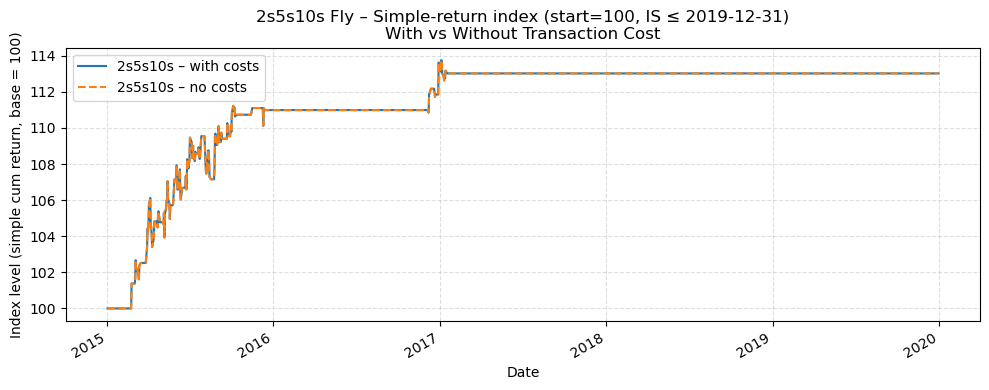

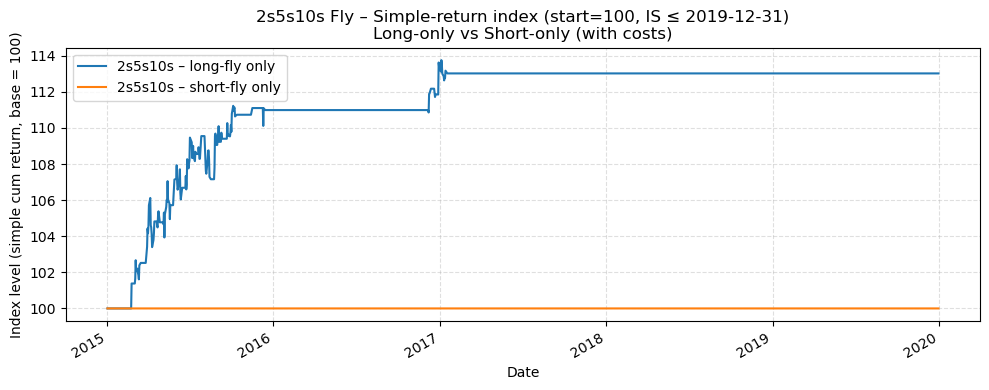

In [ ]:
def run_crd_backtest_with_leg_decomp(
    curve_df: pd.DataFrame,
    signal_df: pd.DataFrame,
    tenors: tuple[float, float, float],
    regime_ok: pd.Series,
    event_block: pd.Series,
    entry_quantile: float = 0.85,
    exit_quantile: float = 0.50,
    cost_bp_per_side: float = COST_BP_PER_SIDE,
) -> pd.DataFrame:
    """
    CRD fly backtest with PnL decomposition into LONG vs SHORT legs.
    """
    T_L, T_B, T_R = tenors
    dates = signal_df.index

    stable_sig = signal_df.loc[regime_ok, "sig_bp"].dropna()
    abs_sig = stable_sig.abs()
    ENTRY_SIG = abs_sig.quantile(entry_quantile)
    EXIT_SIG = abs_sig.quantile(exit_quantile)

    print(f"[{tenors}] ENTRY_SIG: {ENTRY_SIG:.4f}, EXIT_SIG: {EXIT_SIG:.4f}")

    def zero_price_from_curve(curve_row: pd.Series, T: float) -> float:
        y = interp_yield(curve_row, T)
        P, _ = zero_coupon(y, T)
        return P

    prev_curve = None
    prev_pos_dir = 0
    prev_wL = prev_wB = prev_wR = 0.0
    prev_scale = 0.0
    prev_hold_days = 0

    rows = []

    for date in dates:
        curve_today = curve_df.loc[date]
        sig = signal_df.loc[date, "sig_bp"]
        wL_sig = signal_df.loc[date, "wL"]
        wB_sig = signal_df.loc[date, "wB"]
        wR_sig = signal_df.loc[date, "wR"]
        fly_dv01_sig = signal_df.loc[date, "fly_dv01"]

        is_regime_ok = bool(regime_ok.get(date, True))
        is_event_block = bool(event_block.get(date, False))

        daily_pnl_total = 0.0
        daily_pnl_long_legs = 0.0
        daily_pnl_short_legs = 0.0

        if prev_curve is not None and prev_pos_dir != 0 and prev_scale > 0:
            P_L0 = zero_price_from_curve(prev_curve, T_L)
            P_B0 = zero_price_from_curve(prev_curve, T_B)
            P_R0 = zero_price_from_curve(prev_curve, T_R)

            P_L1 = zero_price_from_curve(curve_today, T_L)
            P_B1 = zero_price_from_curve(curve_today, T_B)
            P_R1 = zero_price_from_curve(curve_today, T_R)

            dP_L = P_L1 - P_L0
            dP_B = P_B1 - P_B0
            dP_R = P_R1 - P_R0

            dt = 1.0 / ANNUAL_DAYS
            fund_prev = float(prev_curve.iloc[0])
            y_L_prev = interp_yield(prev_curve, T_L)
            y_B_prev = interp_yield(prev_curve, T_B)
            y_R_prev = interp_yield(prev_curve, T_R)

            carry_L = (y_L_prev - fund_prev) * dt * P_L0
            carry_B = (y_B_prev - fund_prev) * dt * P_B0
            carry_R = (y_R_prev - fund_prev) * dt * P_R0

            notional_L = prev_pos_dir * prev_scale * prev_wL
            notional_B = prev_pos_dir * prev_scale * prev_wB
            notional_R = prev_pos_dir * prev_scale * prev_wR

            pnl_L = notional_L * (dP_L + carry_L)
            pnl_B = notional_B * (dP_B + carry_B)
            pnl_R = notional_R * (dP_R + carry_R)

            pnl_pre_cost = pnl_L + pnl_B + pnl_R

            for pnl_leg, notional_leg in [
                (pnl_L, notional_L),
                (pnl_B, notional_B),
                (pnl_R, notional_R),
            ]:
                if notional_leg > 0:
                    daily_pnl_long_legs += pnl_leg
                elif notional_leg < 0:
                    daily_pnl_short_legs += pnl_leg

            daily_pnl_total = pnl_pre_cost

        new_pos_dir = prev_pos_dir
        new_wL, new_wB, new_wR = prev_wL, prev_wB, prev_wR
        new_scale = prev_scale
        new_hold_days = prev_hold_days

        if is_event_block and prev_pos_dir != 0:
            new_pos_dir = 0
            new_scale = 0.0
            new_hold_days = 0

        elif prev_pos_dir == 0:
            if (not is_event_block) and is_regime_ok and not np.isnan(sig):
                if sig > ENTRY_SIG:
                    new_pos_dir = 1
                    new_wL, new_wB, new_wR = wL_sig, wB_sig, wR_sig
                    new_scale = TARGET_DV01 / max(fly_dv01_sig, 1e-12)
                    new_hold_days = 0
                elif sig < -ENTRY_SIG:
                    new_pos_dir = -1
                    new_wL, new_wB, new_wR = wL_sig, wB_sig, wR_sig
                    new_scale = TARGET_DV01 / max(fly_dv01_sig, 1e-12)
                    new_hold_days = 0

        else:
            new_hold_days = prev_hold_days + 1
            exit_cond = (abs(sig) < EXIT_SIG) or (new_hold_days >= MAX_HOLD_DAYS)
            if exit_cond:
                new_pos_dir = 0
                new_scale = 0.0
                new_hold_days = 0

        trade_cost = 0.0
        if cost_bp_per_side > 0 and new_pos_dir != prev_pos_dir:
            step_units = 1 if (prev_pos_dir == 0 or new_pos_dir == 0) else 2
            trade_cost = step_units * cost_bp_per_side * 1e-4 * TARGET_DV01
            daily_pnl_total -= trade_cost

        rows.append(
            {
                "date": date,
                "sig_bp": sig,
                "pos_dir": prev_pos_dir,
                "daily_pnl_total": daily_pnl_total,
                "daily_pnl_long_legs": daily_pnl_long_legs,
                "daily_pnl_short_legs": daily_pnl_short_legs,
                "hold_days": prev_hold_days,
                "regime_ok": is_regime_ok,
                "event_block": is_event_block,
                "trade_cost": trade_cost,
            }
        )

        prev_curve = curve_today
        prev_pos_dir = new_pos_dir
        prev_wL, prev_wB, prev_wR = new_wL, new_wB, new_wR
        prev_scale = new_scale
        prev_hold_days = new_hold_days

    bt = pd.DataFrame(rows).set_index("date")

    bt["cum_pnl_total"] = bt["daily_pnl_total"].cumsum()
    bt["cum_pnl_long_legs"] = bt["daily_pnl_long_legs"].cumsum()
    bt["cum_pnl_short_legs"] = bt["daily_pnl_short_legs"].cumsum()

    for col in ["daily_pnl_total", "daily_pnl_long_legs", "daily_pnl_short_legs"]:
        ret = (bt[col] / CAPITAL_BASE).fillna(0.0)
        idx = 100.0 * (1.0 + ret.cumsum())
        bt[f"idx_{col.replace('daily_pnl_', '')}"] = idx

    return bt


bt_2s5s10s_decomp = run_crd_backtest_with_leg_decomp(
    curve_df=curve_df,
    signal_df=sig_2s5s10s,
    tenors=BEST_TENORS,
    regime_ok=regime_ok_is,
    event_block=event_block_is,
    entry_quantile=0.85,
    exit_quantile=0.50,
    cost_bp_per_side=COST_BP_PER_SIDE,
)

bt_2s5s10s_decomp = bt_2s5s10s_decomp.loc[:CUTOFF_DATE]

plt.figure(figsize=(10, 4))
bt_2s5s10s_decomp["idx_total"].plot(label="Total strategy (with costs)")
bt_2s5s10s_decomp["idx_long_legs"].plot(label="PnL from LONG legs")
bt_2s5s10s_decomp["idx_short_legs"].plot(label="PnL from SHORT legs")
plt.title("2s5s10s Fly – Simple-return indices (start=100) – Long vs Short legs")
plt.ylabel("Index level")
plt.xlabel("Date")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# Stage 12 – Part C summary statistics (2s5s10s, ≤ 2019-12-31)
- Full Part C panel:
  - Ann. return/vol/Sharpe, Calmar, Sortino.
  - VaR/ES (returns and dollars).
  - Hit rate, avg win/loss, win/loss ratio.
  - Turnover, average holding period, realised cost bps.
  - IC and rank-IC vs CRD signal.
  - PnL attribution: long vs short legs; price vs carry (if available).
  - Event-day PnL summary.

[(2.0, 5.0, 10.0)] ENTRY_SIG: 67317.5357, EXIT_SIG: 41508.7657


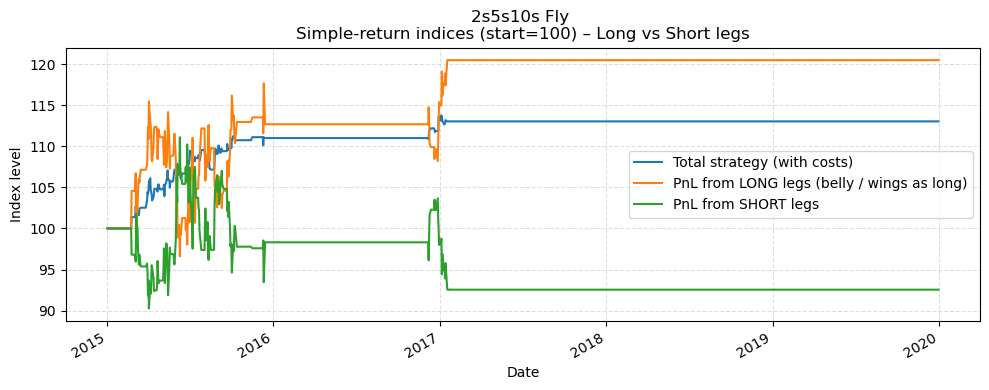

In [ ]:
def compute_partC_stats(
    bt: pd.DataFrame,
    capital_base: float = CAPITAL_BASE,
    trading_days: int = TRADING_DAYS,
    signal: pd.Series | None = None,
    event_block: pd.Series | None = None,
    label: str = "strategy",
) -> pd.Series:
    """
    Part C summary statistics for a single fly backtest (≤ CUTOFF_DATE).
    """
    bt = bt.loc[:CUTOFF_DATE].copy()

    pnl_col = "daily_pnl_net" if "daily_pnl_net" in bt.columns else \
              ("daily_pnl" if "daily_pnl" in bt.columns else "daily_pnl_total")
    pnl = bt[pnl_col].astype(float)
    ret = (pnl / capital_base).replace([np.inf, -np.inf], np.nan).dropna()

    if len(ret) > 1:
        ann_ret = ret.mean() * trading_days
        ann_vol = ret.std(ddof=1) * np.sqrt(trading_days)
        sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
    else:
        ann_ret = ann_vol = sharpe = np.nan

    cum_pnl = pnl.cumsum()
    running_max = cum_pnl.cummax()
    drawdown = running_max - cum_pnl
    max_dd = drawdown.max() if len(drawdown) > 0 else np.nan

    calmar = np.nan
    if max_dd and max_dd > 0 and not np.isnan(ann_ret):
        calmar = ann_ret / (max_dd / capital_base)

    downside_ret = ret[ret < 0]
    if len(downside_ret) > 1:
        downside_vol = downside_ret.std(ddof=1) * np.sqrt(trading_days)
        sortino = ann_ret / downside_vol if downside_vol > 0 else np.nan
    else:
        sortino = np.nan

    hit_rate = (ret > 0).mean() if len(ret) > 0 else np.nan
    wins = ret[ret > 0]
    losses = ret[ret < 0]
    avg_win = wins.mean() if len(wins) > 0 else np.nan
    avg_loss = losses.mean() if len(losses) > 0 else np.nan
    win_loss_ratio = (avg_win / abs(avg_loss)) if (avg_loss is not None and avg_loss < 0) else np.nan

    def var_es(r: pd.Series, alpha: float):
        if len(r) == 0:
            return np.nan, np.nan
        var_level = np.quantile(r, 1 - alpha)
        tail = r[r <= var_level]
        es_level = tail.mean() if len(tail) > 0 else np.nan
        return var_level, es_level

    var95, es95 = var_es(ret, alpha=0.95)
    var99, es99 = var_es(ret, alpha=0.99)

    var95_dollar = var95 * capital_base if not np.isnan(var95) else np.nan
    es95_dollar = es95 * capital_base if not np.isnan(es95) else np.nan
    var99_dollar = var99 * capital_base if not np.isnan(var99) else np.nan
    es99_dollar = es99 * capital_base if not np.isnan(es99) else np.nan

    ic = rank_ic = np.nan
    if signal is not None:
        sig = signal.reindex(bt.index).astype(float)
        fwd_ret = ret.shift(-1)
        valid_mask = (~sig.isna()) & (~fwd_ret.isna())
        if valid_mask.sum() > 5:
            sig_valid = sig[valid_mask]
            fwd_valid = fwd_ret[valid_mask]
            ic = np.corrcoef(sig_valid, fwd_valid)[0, 1]
            sig_rank = sig_valid.rank()
            fwd_rank = fwd_valid.rank()
            rank_ic = np.corrcoef(sig_rank, fwd_rank)[0, 1]

    if "trade_cost" in bt.columns and COST_BP_PER_SIDE is not None and COST_BP_PER_SIDE > 0:
        total_cost = bt["trade_cost"].sum()
        cost_per_side_dollar = COST_BP_PER_SIDE * 1e-4 * TARGET_DV01
        num_sides = total_cost / cost_per_side_dollar if cost_per_side_dollar > 0 else np.nan
    else:
        total_cost = bt.get("trade_cost", pd.Series(0, index=bt.index)).sum()
        num_sides = np.nan

    if not np.isnan(num_sides) and len(bt) > 0:
        turnover_per_year = num_sides / len(bt) * trading_days
    else:
        turnover_per_year = np.nan

    avg_hold_days = med_hold_days = np.nan
    if "hold_days" in bt.columns:
        pos_today = bt["pos_dir"].fillna(0)
        pos_tomorrow = pos_today.shift(-1).fillna(0)
        close_mask = (pos_today != 0) & (pos_tomorrow == 0)
        hold_periods = bt.loc[close_mask, "hold_days"].astype(float).tolist()
        if hold_periods:
            avg_hold_days = np.mean(hold_periods)
            med_hold_days = np.median(hold_periods)

    realized_cost_bp = np.nan
    if not np.isnan(num_sides) and num_sides > 0 and capital_base > 0:
        realized_cost_bp = (total_cost / num_sides) / (TARGET_DV01 * 1e-4)

    total_pnl = pnl.sum()
    total_pnl_long_legs = bt["daily_pnl_long_legs"].sum() if "daily_pnl_long_legs" in bt.columns else np.nan
    total_pnl_short_legs = bt["daily_pnl_short_legs"].sum() if "daily_pnl_short_legs" in bt.columns else np.nan
    total_pnl_price = bt["daily_pnl_price"].sum() if "daily_pnl_price" in bt.columns else np.nan
    total_pnl_carry = bt["daily_pnl_carry"].sum() if "daily_pnl_carry" in bt.columns else np.nan

    event_pnl_mean = event_pnl_std = event_pnl_total = np.nan
    if event_block is not None:
        ev_flag = event_block.reindex(bt.index).fillna(False)
        ev_pnl = pnl[ev_flag]
        if len(ev_pnl) > 0:
            event_pnl_mean = ev_pnl.mean()
            event_pnl_std = ev_pnl.std(ddof=1) if len(ev_pnl) > 1 else 0.0
            event_pnl_total = ev_pnl.sum()

    stats = pd.Series(
        {
            "label": label,
            "ann_return": ann_ret,
            "ann_vol": ann_vol,
            "sharpe": sharpe,
            "max_drawdown_$": max_dd,
            "calmar": calmar,
            "sortino": sortino,
            "VaR_95_ret": var95,
            "ES_95_ret": es95,
            "VaR_99_ret": var99,
            "ES_99_ret": es99,
            "VaR_95_$": var95_dollar,
            "ES_95_$": es95_dollar,
            "VaR_99_$": var99_dollar,
            "ES_99_$": es99_dollar,
            "hit_rate": hit_rate,
            "avg_win_ret": avg_win,
            "avg_loss_ret": avg_loss,
            "win_loss_ratio": win_loss_ratio,
            "total_pnl_$": total_pnl,
            "total_trade_cost_$": total_cost,
            "num_sides": num_sides,
            "turnover_per_year": turnover_per_year,
            "avg_hold_days": avg_hold_days,
            "med_hold_days": med_hold_days,
            "realized_cost_bp_per_side": realized_cost_bp,
            "IC": ic,
            "rank_IC": rank_ic,
            "pnl_long_legs_$": total_pnl_long_legs,
            "pnl_short_legs_$": total_pnl_short_legs,
            "pnl_price_$": total_pnl_price,
            "pnl_carry_$": total_pnl_carry,
            "event_pnl_mean_$": event_pnl_mean,
            "event_pnl_std_$": event_pnl_std,
            "event_pnl_total_$": event_pnl_total,
        }
    )
    return stats


stats_2s5s10s = compute_partC_stats(
    bt=bt_2s5s10s_decomp,
    capital_base=CAPITAL_BASE,
    trading_days=TRADING_DAYS,
    signal=sig_2s5s10s["sig_bp"],
    event_block=event_block_is,
    label="2s5s10s (IS ≤ 2019-12-31)",
)

display(stats_2s5s10s.to_frame("2s5s10s"))

# Stage 13 – Daily returns normality check and 99% VaR (2s5s10s)
- Build IS-only daily return series for 2s5s10s (≤ 2019-12-31).
- Plot:
  - Time series of daily returns.
  - Histogram with normal PDF overlay.
  - QQ-plot vs Normal.
- Compute empirical vs Normal-theory 99% VaR in returns and dollars.
- Compute skewness and excess kurtosis for write-up.

In [ ]:
bt_is = bt_2s5s10s_decomp.loc[:CUTOFF_DATE].copy()

pnl_col = "daily_pnl_net" if "daily_pnl_net" in bt_is.columns else \
          ("daily_pnl" if "daily_pnl" in bt_is.columns else "daily_pnl_total")
pnl = bt_is[pnl_col].astype(float)
ret = (pnl / CAPITAL_BASE).replace([np.inf, -np.inf], np.nan).dropna()

print("Number of IS return observations:", len(ret))
print("Mean daily return:", ret.mean())
print("Std daily return:", ret.std(ddof=1))

plt.figure(figsize=(10, 4))
ret.plot()
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("2s5s10s – Daily Returns (IS ≤ 2019-12-31)")
plt.ylabel("Daily return")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

mu = ret.mean()
sigma = ret.std(ddof=1)

plt.figure(figsize=(8, 4))
_, bins, _ = plt.hist(ret, bins=50, density=True, alpha=0.6)
x_grid = np.linspace(bins[0], bins[-1], 400)
pdf_norm = st.norm.pdf(x_grid, loc=mu, scale=sigma)
plt.plot(x_grid, pdf_norm, linewidth=2)
plt.title("2s5s10s – Return Distribution vs Normal")
plt.xlabel("Daily return")
plt.ylabel("Density")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 5))
st.probplot(ret, dist="norm", sparams=(mu, sigma), plot=plt)
plt.title("2s5s10s – QQ-Plot vs Normal")
plt.tight_layout()
plt.show()

alpha = 0.99
var99_emp_ret = ret.quantile(1 - alpha)
var99_norm_ret = mu + sigma * st.norm.ppf(1 - alpha)

var99_emp_D = var99_emp_ret * CAPITAL_BASE
var99_norm_D = var99_norm_ret * CAPITAL_BASE

print("\n==== 99% VaR (daily, IS-only) ====")
print(f"Empirical VaR 99 (return): {var99_emp_ret:.6f}")
print(f"Normal VaR 99    (return): {var99_norm_ret:.6f}")
print(f"Empirical VaR 99 (dollars): {var99_emp_D:,.2f}")
print(f"Normal VaR 99    (dollars): {var99_norm_D:,.2f}")

skew = st.skew(ret, bias=False)
kurt = st.kurtosis(ret, fisher=True, bias=False)
print("\nSkewness:", skew)
print("Excess kurtosis (0 = normal):", kurt)

,2s5s10s
label,2s5s10s (IS ≤ 2019-12-31)
ann_return,0.026253
ann_vol,0.032871
sharpe,0.798666
max_drawdown_$,272354.460924
calmar,0.963928
sortino,0.460536
VaR_95_ret,-0.000027
ES_95_ret,-0.004258
VaR_99_ret,-0.006707


Number of IS return observations: 1250
Mean daily return: 0.00010417863892582779
Std daily return: 0.0020706845902675273


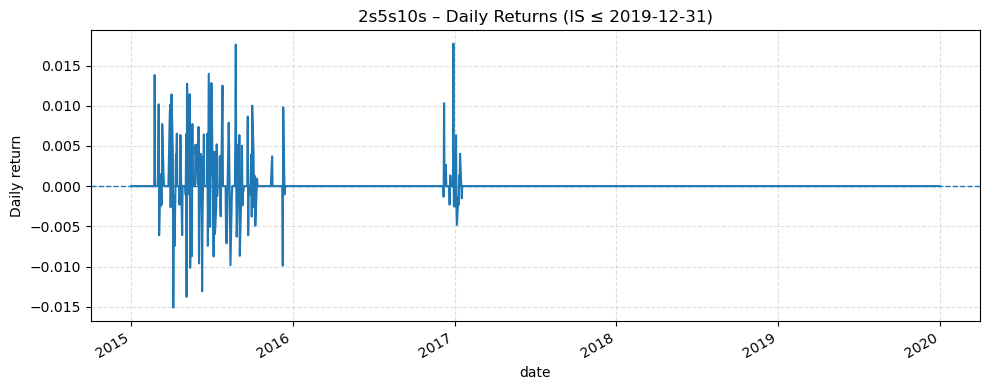

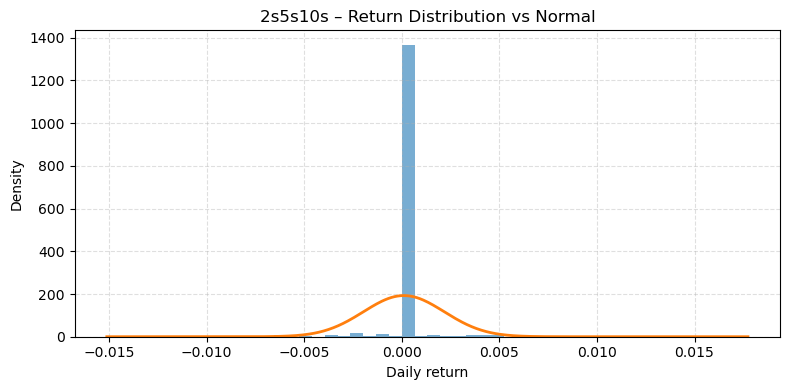

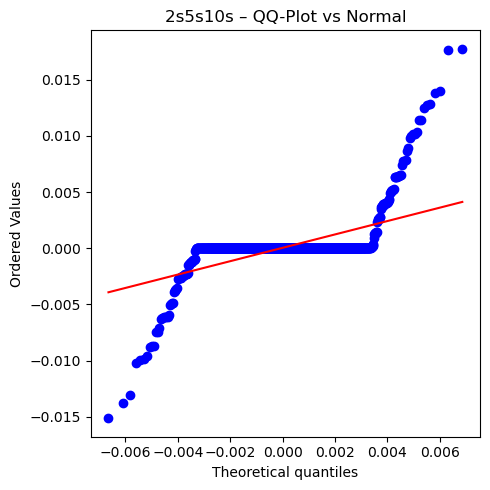


==== 99% VaR (daily, IS-only) ====
Empirical VaR 99 (return): -0.006707
Normal VaR 99    (return): -0.004713
Empirical VaR 99 (dollars): -67,069.65
Normal VaR 99    (dollars): -47,129.54

Skewness: 1.6511461359593371
Excess kurtosis (0 = normal): 26.255272814261726


In [152]:
# ============================================
# Daily returns, normality check, and 99% VaR
# ============================================

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

# 1) Build IS-only daily return series for 2s5s10s
bt_is = bt_2s5s10s_decomp.loc[:CUTOFF_DATE].copy()

pnl_col = "daily_pnl_net" if "daily_pnl_net" in bt_is.columns else "daily_pnl"
pnl = bt_is[pnl_col].astype(float)

ret = (pnl / CAPITAL_BASE).replace([np.inf, -np.inf], np.nan).dropna()

print("Number of IS return observations:", len(ret))
print("Mean daily return:", ret.mean())
print("Std daily return:", ret.std(ddof=1))

# 2) Time series plot of daily returns
plt.figure(figsize=(10, 4))
ret.plot()
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("2s5s10s – Daily Returns (IS ≤ 2019-12-31)")
plt.ylabel("Daily return")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# 3) Histogram with normal PDF overlay
mu = ret.mean()
sigma = ret.std(ddof=1)

plt.figure(figsize=(8, 4))
# histogram of empirical returns
count, bins, _ = plt.hist(ret, bins=50, density=True, alpha=0.6)

# normal pdf on same support
x_grid = np.linspace(bins[0], bins[-1], 400)
pdf_norm = st.norm.pdf(x_grid, loc=mu, scale=sigma)
plt.plot(x_grid, pdf_norm, linewidth=2)

plt.title("2s5s10s – Return Distribution vs Normal")
plt.xlabel("Daily return")
plt.ylabel("Density")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# 4) QQ-plot vs Normal
plt.figure(figsize=(5, 5))
st.probplot(ret, dist="norm", sparams=(mu, sigma), plot=plt)
plt.title("2s5s10s – QQ-Plot vs Normal")
plt.tight_layout()
plt.show()

# 5) 99% VaR – empirical vs normal
alpha = 0.99

# Left-tail (1% worst) – empirical
var99_emp_ret = ret.quantile(1 - alpha)   # should be negative
# Normal-theory VaR: quantile of N(mu, sigma)
var99_norm_ret = mu + sigma * st.norm.ppf(1 - alpha)

# Convert to dollars
var99_emp_D = var99_emp_ret * CAPITAL_BASE
var99_norm_D = var99_norm_ret * CAPITAL_BASE

print("\n==== 99% VaR (daily, IS-only) ====")
print(f"Empirical VaR 99 (return): {var99_emp_ret:.6f}")
print(f"Normal VaR 99    (return): {var99_norm_ret:.6f}")
print(f"Empirical VaR 99 (dollars): {var99_emp_D:,.2f}")
print(f"Normal VaR 99    (dollars): {var99_norm_D:,.2f}")

# Optional: skewness and kurtosis to comment on normality
skew = st.skew(ret, bias=False)
kurt = st.kurtosis(ret, fisher=True, bias=False)  # 0 for normal
print("\nSkewness:", skew)
print("Excess kurtosis (0 = normal):", kurt)


## Stage 14 – Correlation matrix vs major asset classes
- Build daily fly returns (`fly_ret_series`) from `bt_2s5s10s_decomp` if not pre-defined.
- Download proxies via Yahoo (SPY, IEF, HYG, GLD, DBC).
- Compute daily log returns and align with fly returns.
- Compute and (optionally) heatmap plot the correlation matrices

IS fly return sample size: 1250
Date range: 2015-01-02 → 2019-12-31
Asset return shape: (1302, 5)
Asset columns: ['SPY', 'IEF', 'HYG', 'GLD', 'DBC']

Combined matrix shape: (1249, 6)

Correlation matrix (first 6 cols/rows if large):
              Fly_bpDV_ret    SPY    IEF    HYG    GLD    DBC
Fly_bpDV_ret         1.000  0.045 -0.002  0.018  0.020  0.039
SPY                  0.045  1.000 -0.379  0.714 -0.172  0.356
IEF                 -0.002 -0.379  1.000 -0.204  0.469 -0.192
HYG                  0.018  0.714 -0.204  1.000 -0.063  0.437
GLD                  0.020 -0.172  0.469 -0.063  1.000  0.149
DBC                  0.039  0.356 -0.192  0.437  0.149  1.000


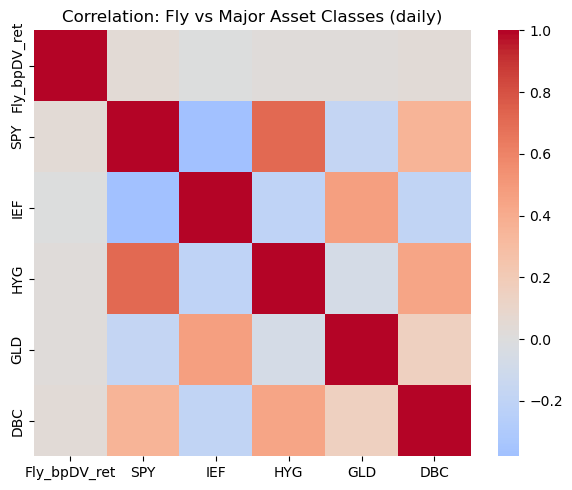

In [ ]:
from datetime import datetime

if "fly_ret" in globals() and isinstance(fly_ret, (pd.Series, pd.DataFrame)):
    fly_ret_series = fly_ret.copy()
    if isinstance(fly_ret_series, pd.DataFrame):
        fly_ret_series = fly_ret_series.select_dtypes(include=[np.number]).iloc[:, 0]
    if not isinstance(fly_ret_series.index, pd.DatetimeIndex):
        fly_ret_series.index = pd.to_datetime(fly_ret_series.index, errors="coerce")
else:
    _tmp = bt_2s5s10s_decomp.copy()
    _tmp.index = pd.to_datetime(_tmp.index)
    _tmp["ret"] = _tmp[pnl_col] / CAPITAL_BASE
    fly_ret_series = _tmp["ret"].asfreq("B").fillna(0.0)

fly_ret_series = fly_ret_series.sort_index()
is_start = fly_ret_series.index.min()
is_end = fly_ret_series.index.max()
print(f"IS fly return sample size: {fly_ret_series.shape[0]}")
print(f"Date range: {is_start.date()} → {is_end.date()}")

tickers = ["SPY", "IEF", "HYG", "GLD", "DBC"]

def fetch_assets_yf(
    tickers: list[str],
    start: pd.Timestamp,
    end: pd.Timestamp,
) -> pd.DataFrame:
    """
    Download asset prices from Yahoo and return daily log returns.
    """
    try:
        import yfinance as yf
    except Exception:
        print("[INFO] yfinance not available; skipping asset downloads.")
        return pd.DataFrame(index=pd.date_range(start, end, freq="B"))

    try:
        print(f"Downloading Yahoo data from {start:%Y-%m-%d} to {end:%Y-%m-%d}")
        px = yf.download(
            tickers=" ".join(tickers),
            start=start.strftime("%Y-%m-%d"),
            end=(end + pd.Timedelta(days=1)).strftime("%Y-%m-%d"),
            auto_adjust=True,
            progress=False,
            group_by="ticker",
            threads=False,
        )

        if isinstance(px.columns, pd.MultiIndex):
            adj = {}
            for t in tickers:
                if (t, "Adj Close") in px.columns:
                    adj[t] = px[(t, "Adj Close")]
                elif (t, "Close") in px.columns:
                    adj[t] = px[(t, "Close")]
            if len(adj) == 0:
                return pd.DataFrame(index=pd.date_range(start, end, freq="B"))
            adj = pd.DataFrame(adj)
        else:
            if "Adj Close" in px.columns:
                adj = px[["Adj Close"]].rename(columns={"Adj Close": tickers[0]})
            elif "Close" in px.columns:
                adj = px[["Close"]].rename(columns={"Close": tickers[0]})
            else:
                return pd.DataFrame(index=pd.date_range(start, end, freq="B"))

        adj = adj.sort_index().asfreq("B").ffill()
        ret = np.log(adj).diff().dropna(how="all")
        return ret
    except Exception as e:
        print(f"[WARN] yfinance download failed: {e}")
        return pd.DataFrame(index=pd.date_range(start, end, freq="B"))


asset_returns = fetch_assets_yf(tickers, is_start, is_end)

print("Asset return shape:", asset_returns.shape)
print("Asset columns:", asset_returns.columns.tolist())

fly_df = fly_ret_series.rename("Fly_ret").to_frame().asfreq("B").dropna()

if asset_returns.empty:
    print("[INFO] No asset data available; computing corr with strategy alone (trivial).")
    combined_ret = fly_df.copy()
else:
    combined_ret = fly_df.join(asset_returns, how="inner").dropna(how="any")

if combined_ret.shape[1] <= 1:
    print("[INFO] Not enough series to compute a correlation matrix.")
    corr_mat = pd.DataFrame()
else:
    corr_mat = combined_ret.corr()

print("\nCombined matrix shape:", combined_ret.shape)
if not corr_mat.empty:
    print("\nCorrelation matrix (rounded):")
    print(corr_mat.round(3))

    try:
        import seaborn as sns
        plt.figure(figsize=(6, 5))
        sns.heatmap(corr_mat.round(3), annot=False, cmap="coolwarm", center=0)
        plt.title("Correlation: Fly vs Major Asset Classes (daily)")
        plt.tight_layout()
        plt.show()
    except Exception:
        plt.figure(figsize=(6, 5))
        im = plt.imshow(corr_mat.values, cmap="coolwarm", vmin=-1, vmax=1)
        plt.colorbar(im)
        plt.xticks(range(corr_mat.shape[1]), corr_mat.columns, rotation=90)
        plt.yticks(range(corr_mat.shape[0]), corr_mat.index)
        plt.title("Correlation: Fly vs Major Asset Classes (daily)")
        plt.tight_layout()
        plt.show()
else:
    print("[INFO] Skipped correlation heatmap (no asset data).")